In [145]:
import skimage as sk
import matplotlib.pyplot as plt
from dottamine import dotim
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter, rotate
from scipy.interpolate import griddata
import tifffile as tiff

In [347]:
time_dome = str(3)

In [348]:
image = sk.io.imread('./../ppujol/zmap/62_denoised time '+time_dome+'.tif')

In [349]:
image_r = np.transpose(image, axes=(1,0,2))
image_r = np.transpose(image_r, axes=(2, 1, 0))

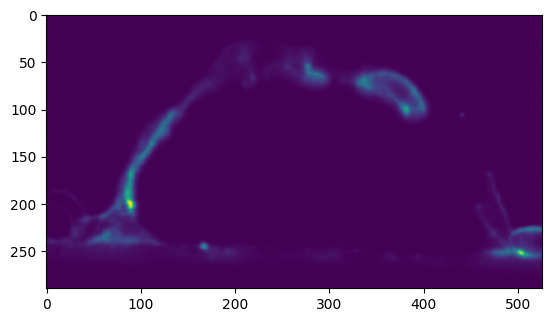

In [350]:
plt.imshow(image_r[300])

In [351]:
def normalize_image(im, mult_factor = 1):
    im = np.array(im)
    norm_im = (im - im.min()) / (im.max()-im.min()) * mult_factor
    return norm_im

In [7]:
doter = dotim(image_r, is2D=False, treat_3D_as_2D=False)
mask_r = doter.get_mask(times=3, binshape=(2,2,2), v='+')

Convolving: 1/3


KeyboardInterrupt: 

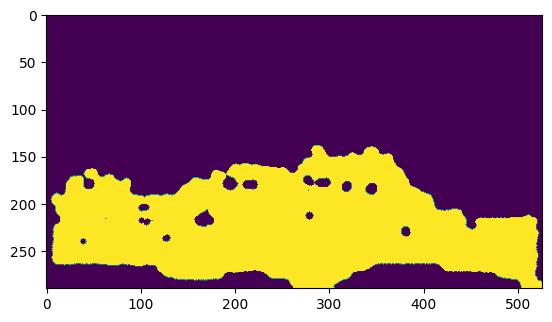

In [352]:
plt.imshow(mask_r[100])

In [ ]:
mask_r = mask_r.astype(np.uint16)

In [240]:
import tifffile as tiff
tiff.imwrite("./../ppujol/zmap/62 t"+time_dome+" mask.tif", mask_r2, imagej=True)

After doing the first mask, remove the found cells from the original image and try again dotamine or do CLAHE before in order to highlight the missing cells.

In [ ]:
def clahe(image):
    flat_image = image.flatten()
    clahe = cv2.createCLAHE(clipLimit=1, tileGridSize=(2,2))
    cl1 = clahe.apply(normalize_image(flat_image, 255).astype(np.uint8))
    clahe_image = cl1.reshape(image.shape)

    return clahe_image

clahe_image = clahe(image=image)

In [242]:
# tiff.imwrite("./../ppujol/zmap/62 t3 clahe.tif", clahe_image, imagej=True)

3D curvilinear interpolation

In [554]:
mask_r = sk.io.imread('./../ppujol/zmap/62 t'+time_dome+' mask.tif')

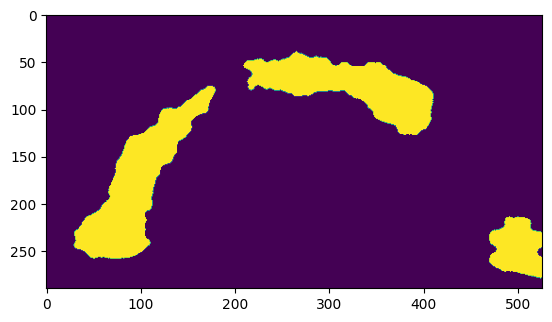

In [555]:
plt.imshow(mask_r[300])

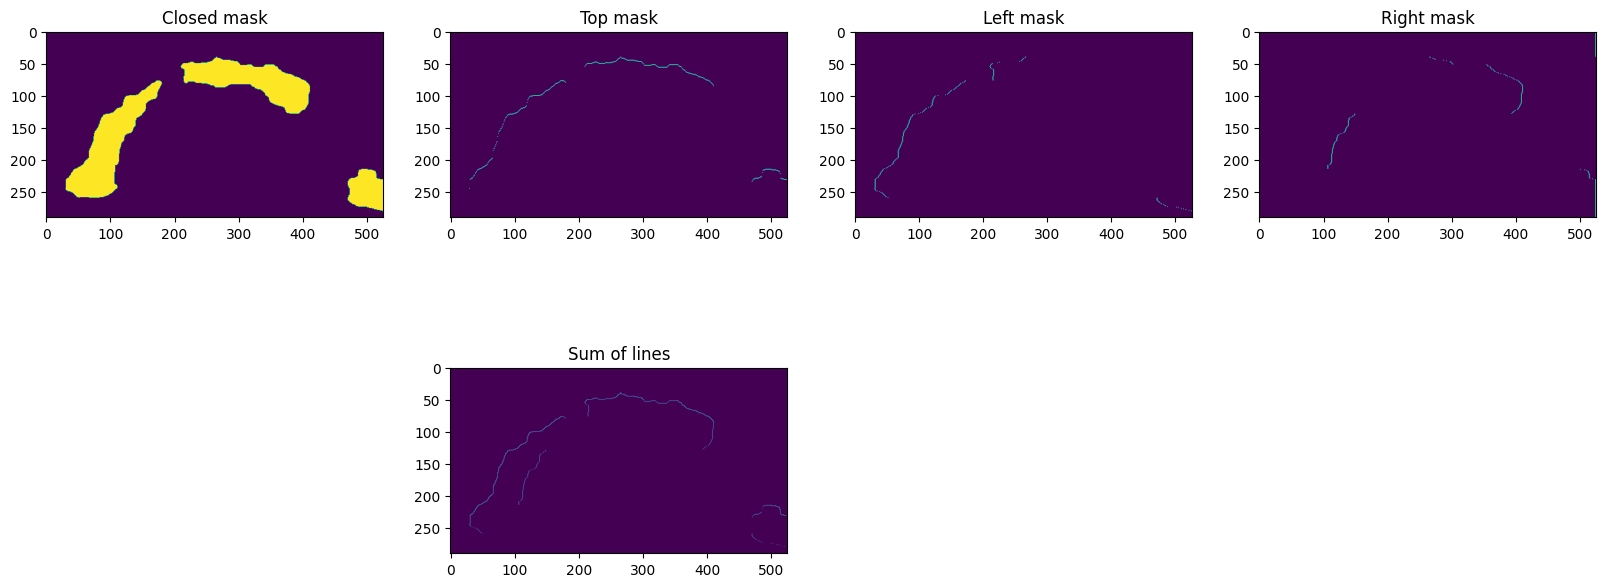

In [556]:
closed_mask_r = []
for i in mask_r:
    full = cv2.morphologyEx(i, cv2.MORPH_CLOSE, np.ones((10, 10)))
    closed_mask_r.append(full)


closed_mask = np.array(closed_mask_r)

## Find the top line of the mask
first_nonzero_indices = np.argmax(closed_mask != 0, axis=1)
top_mask = np.zeros_like(closed_mask)
top_mask[np.arange(closed_mask.shape[0])[:, None, None], first_nonzero_indices[:, None, :], np.arange(closed_mask.shape[2])] = 1 # Top mask is a 3D array that contains the top line of the actual mask

## Find the left line of the mask
first_left_nonzero_indices = np.argmax(closed_mask != 0, axis=2)
left_mask = np.zeros_like(closed_mask)
left_mask[np.arange(closed_mask.shape[0])[:, None, None], np.arange(closed_mask.shape[1]), first_left_nonzero_indices[None, :, None]] = 1 # Top mask is a 3D array that contains the left line of the actual mask

## Find the right line of the mask
last_right_nonzero_indices = closed_mask.shape[2] - np.argmax(closed_mask[:, :, ::-1] != 0, axis=2) - 1
right_mask = np.zeros_like(closed_mask)
right_mask[np.arange(closed_mask.shape[0])[:, None, None], np.arange(closed_mask.shape[1]), last_right_nonzero_indices[None, :, None]] = 1 # Right mask is a 3D array that contains the right line of the actual mask

sum_mask = top_mask+left_mask+right_mask
sum_mask[0, :, :] = 0
sum_mask[-1, :, :] = 0
sum_mask[:, 0, :] = 0
sum_mask[:, -1, :] = 0
sum_mask[:, :, 0] = 0
sum_mask[:, :, -1] = 0


plt.figure(figsize=(20,8))
y = 300
plt.subplot(241)
plt.title('Closed mask')
plt.imshow(closed_mask[y])
plt.subplot(242)
plt.title('Top mask')
plt.imshow(top_mask[y])
plt.subplot(243)
plt.title('Left mask')
plt.imshow(left_mask[y])
plt.subplot(244)
plt.title('Right mask')
plt.imshow(right_mask[y])

plt.subplot(246)
plt.title('Sum of lines')
plt.imshow(sum_mask[y])

In [558]:
import tifffile as tiff
sum_mask = np.transpose(sum_mask, axes=(1,2,0))
tiff.imwrite("./../ppujol/zmap/62 t5 sum lines.tif", sum_mask, imagej=True)

In [356]:
sum_mask = sk.io.imread("./../ppujol/zmap/62 t"+time_dome+" sum lines.tif")

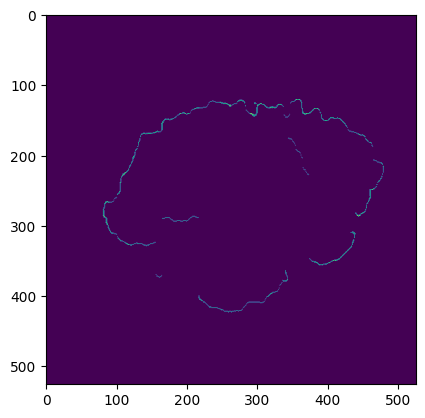

In [559]:

plt.imshow(sum_mask[100])

In [560]:
sum_mask_r = np.transpose(sum_mask, axes=(1,0,2))
sum_mask_r = np.transpose(sum_mask_r, axes=(2, 1, 0))

In [904]:
hull = []

for i in sum_mask:
    hull.append(sk.morphology.convex_hull_image(i))

hull = np.array(hull)
hull = hull.astype(np.uint8)

/tmp/ipykernel_667880/546418270.py:4: UserWarning: Input image is entirely zero, no valid convex hull. Returning empty image
  hull.append(sk.morphology.convex_hull_image(i))


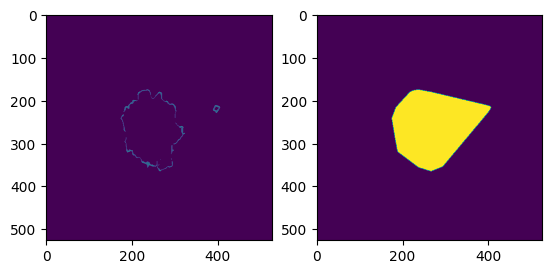

In [903]:
hull_2 = hull[:, :, :]

plt.figure()
plt.subplot(121)
plt.imshow(sum_mask[50])
plt.subplot(122)
plt.imshow(hull[50])

In [166]:
tiff.imwrite("./../ppujol/zmap/62 t"+time_dome+" hull.tif", hull_2, imagej=True)
tiff.imwrite("./../ppujol/zmap/62 t"+time_dome+" sum lines.tif", sum_mask, imagej=True)

# Get the points that represent the surface of the hull:

In [563]:
volume = sk.io.imread("./../ppujol/zmap/62 t"+time_dome+" hull.tif")

In [564]:
def find_points(volume):

    # Pad the volume with zeros on all sides to handle edge cases
    padded_volume = np.pad(volume, 1, mode='constant', constant_values=0)

    # Use np.where to find points with value 1 and neighbors with value 0
    result_indices = np.where(
        (padded_volume[1:-1, 1:-1, 1:-1] == 1) & 
        ((padded_volume[:-2, 1:-1, 1:-1] == 0) |
        (padded_volume[2:, 1:-1, 1:-1] == 0) |
        (padded_volume[1:-1, :-2, 1:-1] == 0) |
        (padded_volume[1:-1, 2:, 1:-1] == 0) |
        (padded_volume[1:-1, 1:-1, :-2] == 0) |
        (padded_volume[1:-1, 1:-1, 2:] == 0))
    )

    # Adjust indices to original volume coordinates
    result_points = [(z, y, x) for z, y, x in set(zip(*result_indices))]
    result_points = np.array(result_points)

    return result_points

In [565]:
result_points = find_points(volume=volume)

surface = np.zeros(volume.shape)

for i in result_points:
    z = i[0]-1
    y = i[1]-1
    x = i[2]-1
    surface[z,y,x] = 1

surface = surface.astype(np.uint16)

In [170]:
tiff.imwrite("./../ppujol/zmap/62 t"+time_dome+" hull surface.tif", surface, imagej=True)

In [566]:
volume.shape

(290, 526, 526)

Now we have a hull mask of the dome. We should use it to find the brigthest point around.

First do it VERTICALLY

In [899]:
volume_r = np.transpose(volume, axes=(1,0,2))
volume_r = np.transpose(volume_r, axes=(2, 1, 0))

surface_r = np.transpose(surface, axes=(1,0,2))
surface_r = np.transpose(surface_r, axes=(2,1,0))

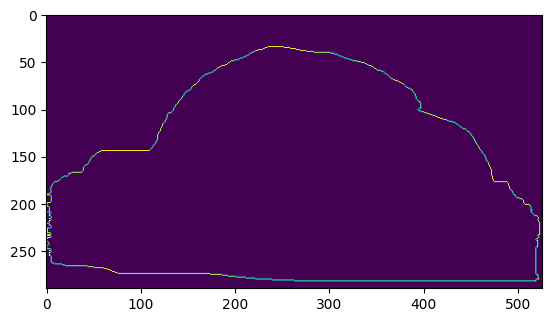

In [901]:
plt.imshow(surface_r[200])

In [568]:
volume_r.shape

(526, 290, 526)

In [569]:
def first_nonzero(volume_r):


    first_nonzero_indices = np.argmax(volume_r != 0, axis=1)

    ## Move up or down the line
    first_nonzero_indices = first_nonzero_indices # Units to move the line. If > 0  the line will be lower, useful to get the basal? If < 0 the line will be higher, useful for apical.
    first_nonzero_indices[first_nonzero_indices < 0] = 0
    first_nonzero_indices[first_nonzero_indices >= volume_r.shape[1]] = volume_r.shape[1]-1
    ## Fi move up or down the line

    top_mask_r = np.zeros_like(volume_r)
    top_mask_r[np.arange(volume_r.shape[0])[:, None, None], first_nonzero_indices[:, None, :], np.arange(volume_r.shape[2])] = 1 # Top mask is a 3D array that contains the top line of the actual mask
    top_mask_r[:,0,:] = 0

    return top_mask_r

hull_mask_r = first_nonzero(volume_r)


In [570]:
hull_mask = np.transpose(hull_mask_r, axes=(1,2,0))

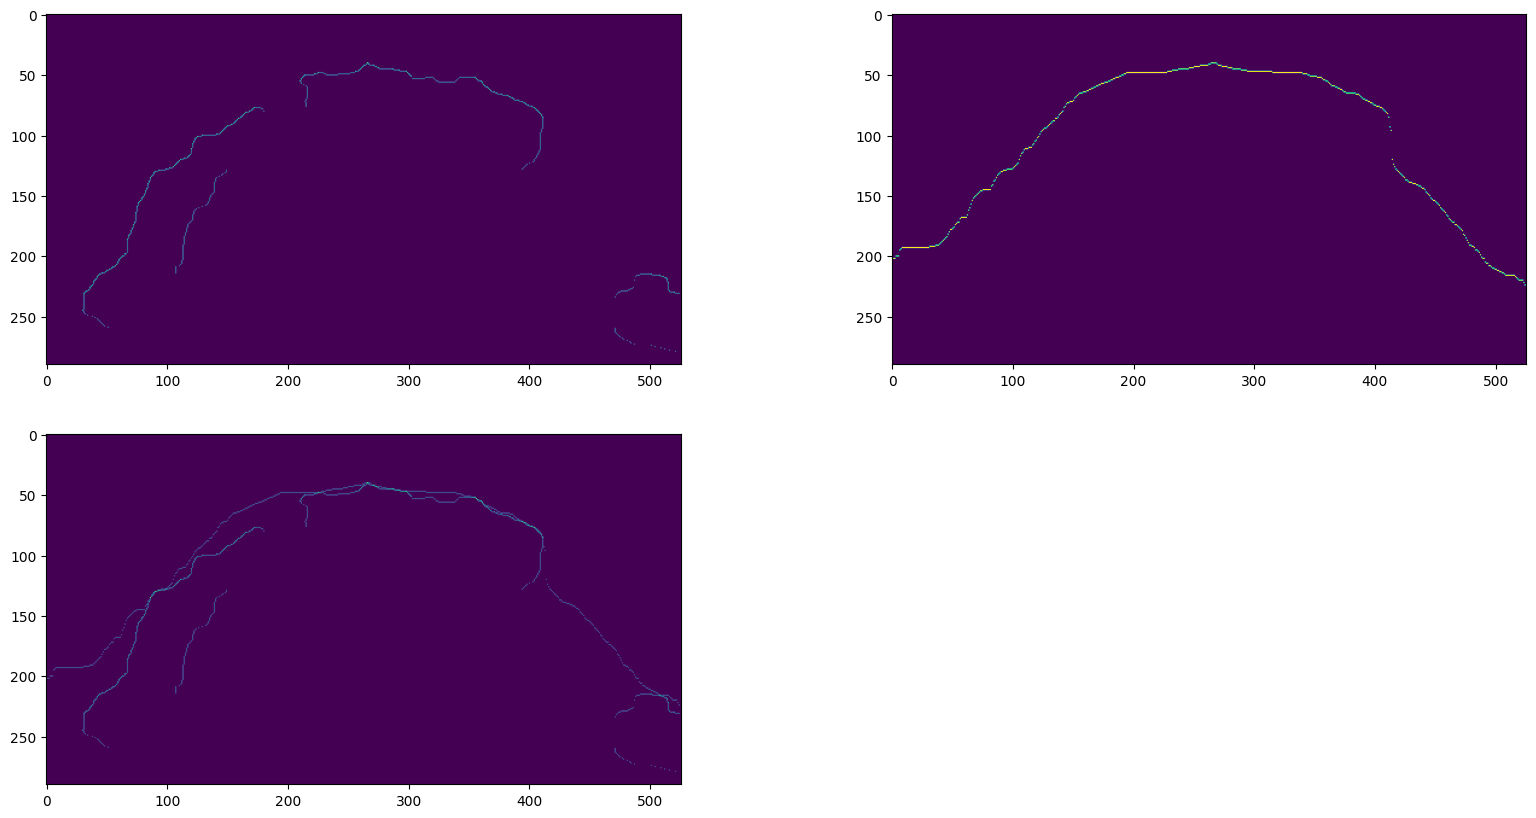

In [571]:
y = 300
plt.figure(figsize=(20,10))
plt.subplot(221)
plt.imshow(sum_mask_r[y])
plt.subplot(222)
plt.imshow(hull_mask_r[y])
plt.subplot(223)
plt.imshow(sum_mask_r[y] + hull_mask_r[y])


In [606]:
hull_mask = hull_mask.astype(np.float64)
filtered = gaussian_filter(hull_mask, 20)
filtered = normalize_image(filtered)
epithelial = filtered*image

In [607]:
sum_mask = sum_mask.astype(np.float64)
filtered_sum = gaussian_filter(sum_mask, 20)
filtered_sum = normalize_image(filtered_sum)
epithelial_sum = filtered_sum*image

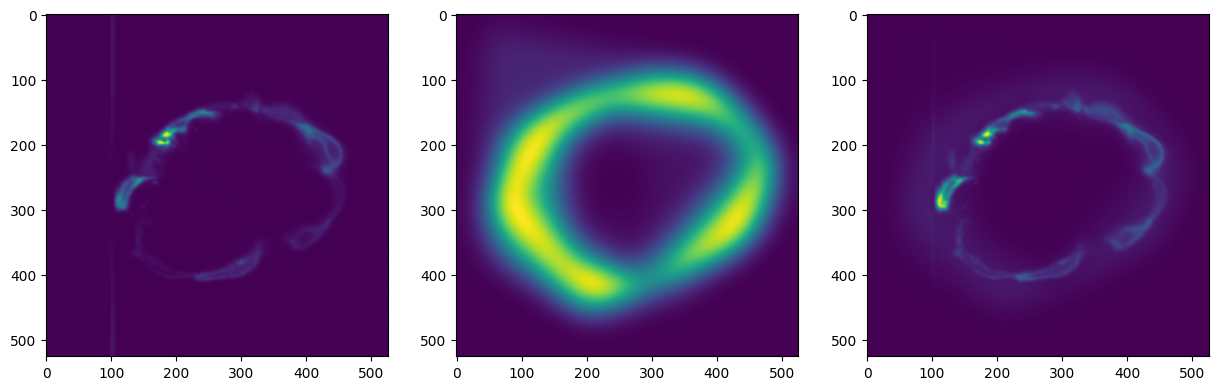

In [895]:
plt.figure(figsize=(15,10))

plt.subplot(231)
plt.imshow(image[100])
plt.subplot(232)
plt.imshow(filtered[100])
plt.subplot(233)
plt.imshow(epithelial[100])

In [615]:
epithelial_r = np.transpose(epithelial, axes=(1,0,2))
epithelial_r = np.transpose(epithelial_r, axes=(2, 1, 0))

filtered_r = np.transpose(filtered, axes=(1,0,2))
filtered_r = np.transpose(filtered_r, axes=(2, 1, 0))

filtered_sum_r = np.transpose(filtered_sum, axes=(1,0,2))
filtered_sum_r = np.transpose(filtered_sum_r, axes=(2, 1, 0))

epithelial_sum_r = np.transpose(epithelial_sum, axes=(1,0,2))
epithelial_sum_r = np.transpose(epithelial_sum_r, axes=(2, 1, 0))

In [605]:
print(normalize_image(filtered).max())

1.0


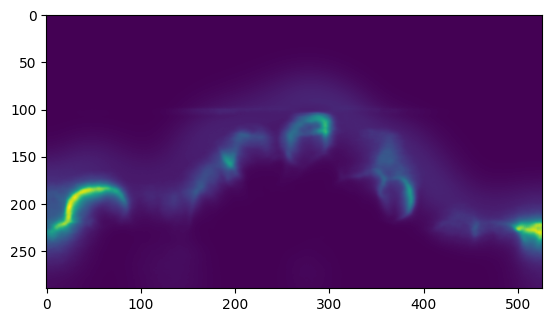

In [616]:
plt.imshow(epithelial_sum_r[100])

# Do the falling line

In [877]:
def shape_finder_2D(height_mask):

    angles = [i for i in range(-40, 40+1, 20)]
    # angles = [-40]
    total_cell_mask = np.zeros(shape=(height_mask.shape))

    for angle in angles:

        ## Rotate the masked image.        
        rot_height_mask = rotate(height_mask, angle, reshape=False) # Be careful of the reshape=False
        # rot_sum_mask = rotate(sum_mask, angle, reshape=False) # Rotate the mask line
        # plt.figure(figsize=(20,20))
        # plt.imshow(rot_height_mask)
        ## Find the border of the cell which is the maximum of this masked image.
        cell_border = []

        ## Get the position of the maximum intensity.
        for i in range(rot_height_mask.shape[1]):
            col = rot_height_mask[:, i]
            max_pos = np.argmax(col == max(col))
            # col_line = rot_sum_mask[:, i]
            # max_pos_sum_mask = np.argmax(col_line == max(col_line))

            # print(i, max(col), col.mean(), col.std())

            # max_pos = find_first_local_max(col)
            # and abs(max_pos_sum_mask-max_pos)/len(col) <= 0.05
            if max_pos <= len(col)*0.95 and max_pos >= len(col)*0.05 and max(col) >= col.mean()+2*col.std(): # 3 IS SUPER CONSERVATIVE
                cell_border.append(max_pos) # Search for the first max
            else:
                cell_border.append('-')

        ## Put the positions in a matrix as we have done with the smoothed line before.
        cell_top_mask_rot = np.zeros_like(rot_height_mask)
        for i in range(cell_top_mask_rot.shape[1]):
            if cell_border[i] != '-':
                cell_top_mask_rot[cell_border[i], i] = 1
                # print(i)

        ## Rotate the matrix to have it horizontal as the original image.
        cell_top_mask_rot = rotate(cell_top_mask_rot, -angle, reshape=False)
        cell_top_mask_rot[cell_top_mask_rot < 0] = 0
        horizontal_cut = 4
        cell_top_mask_rot[:, :horizontal_cut] = 0
        cell_top_mask_rot[:, -horizontal_cut:] = 0
        total_cell_mask += cell_top_mask_rot

    return np.array(total_cell_mask)

In [860]:
def shape_finder_2D_v2(hull_lines, hull_mask, sum_lines, sum_mask):

    angles = [i for i in range(-40, 40+1, 20)]
    # angles = [40]
    total_cell_mask = np.zeros(shape=(hull_lines.shape))

    for angle in angles:

        ## Rotate the masked image.        
        rot_hull_lines = rotate(hull_lines, angle, reshape=False) # Be careful of the reshape=False
        rot_hull_mask = rotate(hull_mask, angle, reshape=False)
        rot_sum_lines = rotate(sum_lines, angle, reshape=False)
        rot_sum_mask = rotate(sum_mask, angle, reshape=False)
        cell_border = []

        ## Get the position of the maximum intensity.
        for i in range(rot_hull_lines.shape[1]):
            col_hull_lines = rot_hull_lines[:, i]
            max_pos_hull_lines = np.argmax(col_hull_lines == max(col_hull_lines))
            col_hull_mask = rot_hull_mask[:, i]
            max_pos_hull_mask = np.argmax(col_hull_mask == max(col_hull_mask))

            col_sum_lines = rot_sum_lines[:, i]
            max_pos_sum_lines = np.argmax(col_sum_lines == max(col_sum_lines))
            col_sum_mask = rot_sum_mask[:, i]
            max_pos_sum_mask = np.argmax(col_sum_mask == max(col_sum_mask))

            # print(max_pos_hull_lines, max_pos_hull_mask, abs(max_pos_hull_lines-max_pos_hull_mask)/max_pos_hull_mask)


            #   Check that the position is lower than the col ------ Check that the position is grater than the bottom -- 
            if ((max_pos_hull_lines <= len(col_hull_lines)*0.90) and (max_pos_hull_lines >= len(col_hull_lines)*0.1) and 
                # Check that the column has some variation 3 is super conservative ------- Check the distance to the original line
                (max(col_hull_lines) >= col_hull_lines.mean()+3*col_hull_lines.std()) and (abs(max_pos_hull_lines-max_pos_hull_mask)/max_pos_hull_mask >= 0.05)): # 3 IS SUPER CONSERVATIVE
                cell_border.append(max_pos_hull_lines) # Search for the first max

            #   Check that the position is lower than the col ------ Check that the position is grater than the bottom -- 
            elif ((max_pos_sum_lines <= len(col_sum_lines)*0.90) and (max_pos_sum_lines >= len(col_sum_lines)*0.1) and 
                # Check that the column has some variation 3 is super conservative ------- Check the distance to the original line
                (max(col_sum_lines) >= col_sum_lines.mean()+2*col_sum_lines.std()) and (abs(max_pos_sum_lines-max_pos_sum_mask)/max_pos_sum_mask >= 0.05)): # 3 IS SUPER CONSERVATIVE
                cell_border.append(max_pos_sum_lines) # Search for the first max

            else:
                cell_border.append('-')
                # cell_border.append(max_pos_sum_lines) 

        ## Put the positions in a matrix as we have done with the smoothed line before.
        cell_top_mask_rot = np.zeros_like(rot_hull_lines)
        for i in range(cell_top_mask_rot.shape[1]):
            if cell_border[i] != '-':
                cell_top_mask_rot[cell_border[i], i] = 1

        ## Rotate the matrix to have it horizontal as the original image.
        cell_top_mask_rot = rotate(cell_top_mask_rot, -angle, reshape=False)
        cell_top_mask_rot[cell_top_mask_rot < 0] = 0
        horizontal_cut = 4
        cell_top_mask_rot[:, :horizontal_cut] = 0
        cell_top_mask_rot[:, -horizontal_cut:] = 0
        total_cell_mask += cell_top_mask_rot

    return np.array(total_cell_mask)

In [743]:
print(epithelial_sum_r[slice].max(), epithelial_r[slice].max())

197.57682204137998 208.66707430864406


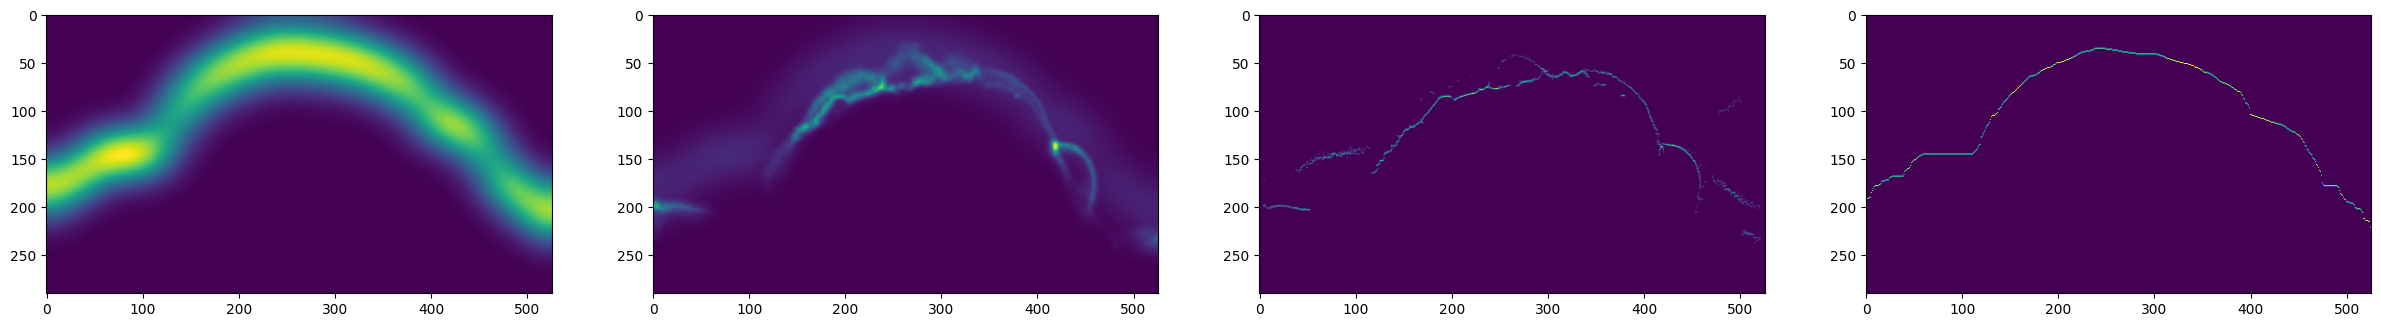

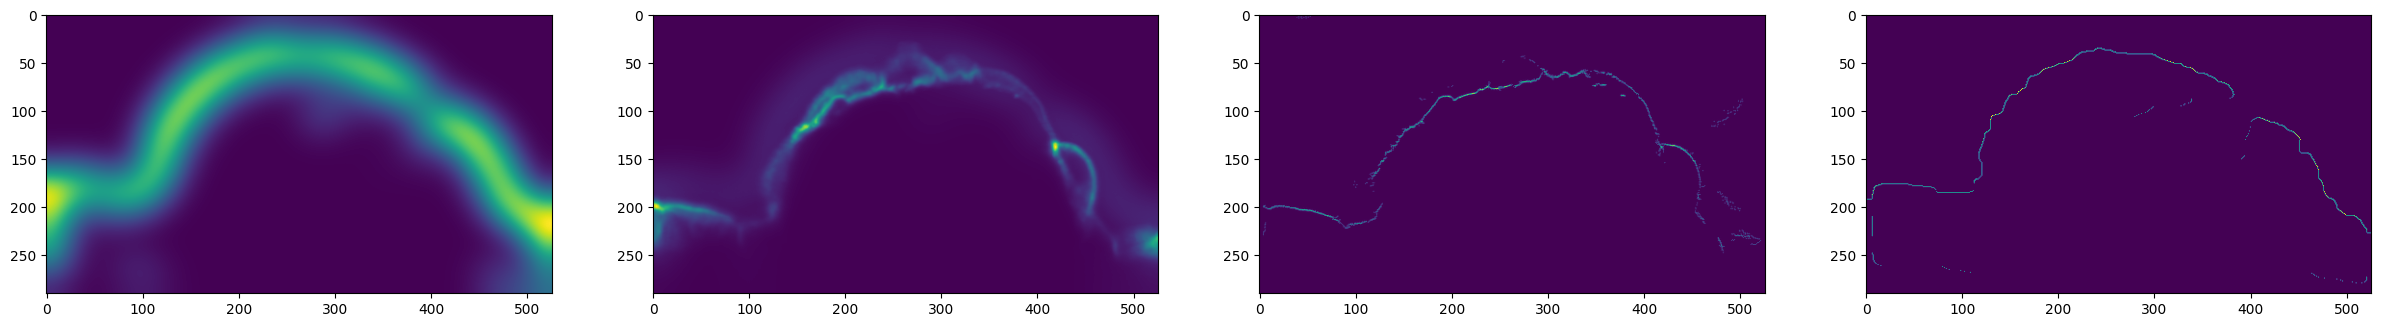

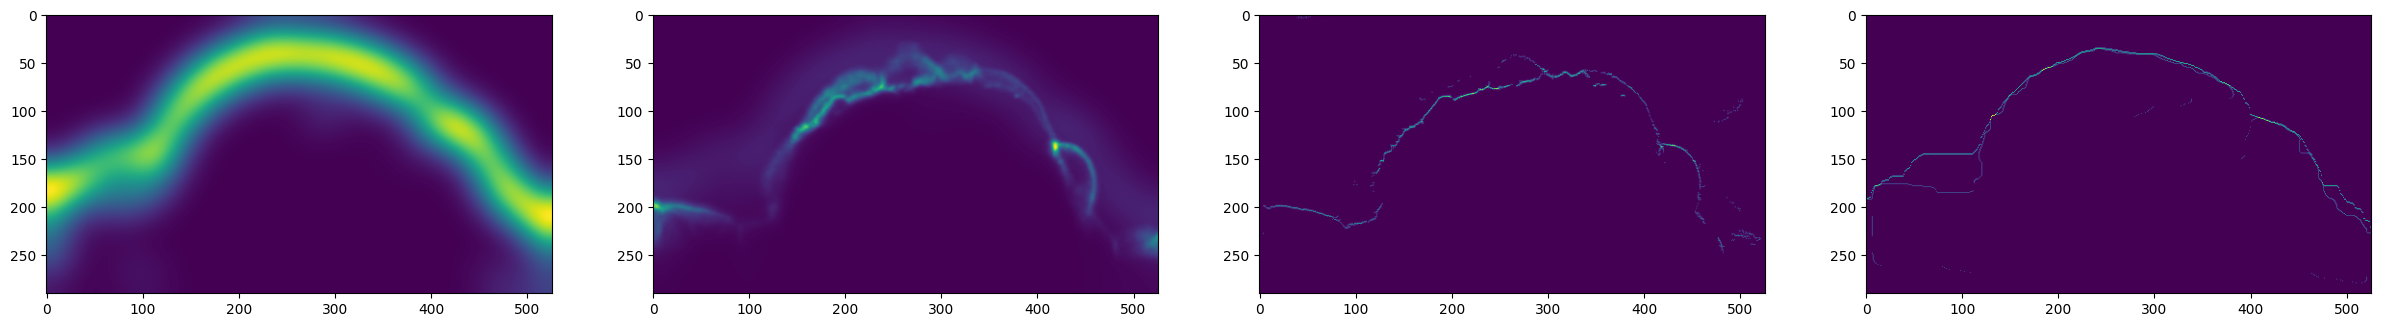

In [861]:
slice = 200
plt.figure(figsize=(30,20))
plt.subplot(341)
plt.imshow(filtered_r[slice])
plt.subplot(342)
plt.imshow(epithelial_r[slice])
plt.subplot(343)
plt.imshow(shape_finder_2D(epithelial_r[slice]))
plt.subplot(344)
plt.imshow(hull_mask_r[slice])

plt.figure(figsize=(30,20))
plt.subplot(341)
plt.imshow(filtered_sum_r[slice])
plt.subplot(342)
plt.imshow(epithelial_sum_r[slice])
plt.subplot(343)
plt.imshow(shape_finder_2D(epithelial_sum_r[slice]))
plt.subplot(344)
plt.imshow(sum_mask_r[slice])

plt.figure(figsize=(30,20))
plt.subplot(341)
plt.imshow(filtered_sum_r[slice]+filtered_r[slice])
plt.subplot(342)
plt.imshow(rotate(normalize_image(epithelial_sum_r[slice])+normalize_image(epithelial_r[slice]), -0, reshape=False))
plt.subplot(343)
plt.imshow(rotate(shape_finder_2D_v2(normalize_image(epithelial_r[slice]), normalize_image(hull_mask_r[slice]), normalize_image(epithelial_sum_r[slice]), normalize_image(sum_mask_r[slice])), -0, reshape=False)) # *(filtered_sum_r[slice]+filtered_r[slice])
plt.subplot(344)
plt.imshow(sum_mask_r[slice]+hull_mask_r[slice]*3)

In [862]:
surface_cells_r = []
c = 0
total = epithelial_r.shape[0]
for i, j, k, l in zip(normalize_image(epithelial_r), normalize_image(hull_mask_r), normalize_image(epithelial_sum_r), normalize_image(sum_mask_r)):
    surface_cells_r.append(shape_finder_2D_v2(i, j, k, l))
    c+=1
    print(f"{c}/{total}", end='\r')
surface_cells_r = np.array(surface_cells_r)

/tmp/ipykernel_667880/1715059348.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  (max(col_hull_lines) >= col_hull_lines.mean()+3*col_hull_lines.std()) and (abs(max_pos_hull_lines-max_pos_hull_mask)/max_pos_hull_mask >= 0.05)): # 3 IS SUPER CONSERVATIVE
/tmp/ipykernel_667880/1715059348.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  (max(col_sum_lines) >= col_sum_lines.mean()+2*col_sum_lines.std()) and (abs(max_pos_sum_lines-max_pos_sum_mask)/max_pos_sum_mask >= 0.05)): # 3 IS SUPER CONSERVATIVE


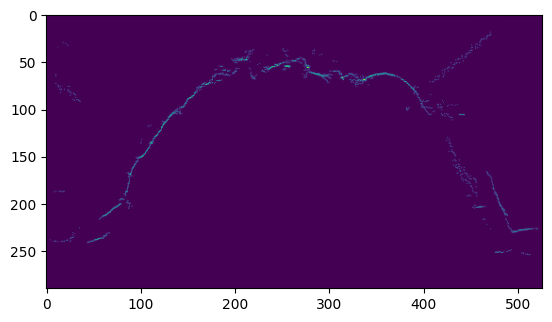

In [863]:
plt.imshow(surface_cells_r[300])

In [864]:
surface_cells_r_2 = surface_cells_r*(filtered_sum_r+filtered_r)

In [865]:
surface_cells = np.transpose(surface_cells_r, axes=(1,2,0))
surface_cells = surface_cells.astype(np.uint16)
surface_cells_2 = np.transpose(surface_cells_r_2, axes=(1,2,0))
surface_cells_2 = surface_cells_2.astype(np.uint16)
# mean_indices_3d = mean_indices_3d.astype(np.uint16)

tiff.imwrite("./../ppujol/zmap/62 t"+time_dome+" cell surface hull sum first conservative.tif", surface_cells, imagej=True)

In [716]:
# surface_cells = np.transpose(surface_cells_r, axes=(1,2,0))
# surface_cells = surface_cells.astype(np.uint16)
# # mean_indices_3d = mean_indices_3d.astype(np.uint16)
# tiff.imwrite("./../ppujol/zmap/62 t"+time_dome+" cell surface.tif", surface_cells, imagej=True)

In [872]:
dots_mask_mask = surface_cells.astype(np.float64)
filtered_mask_mask = gaussian_filter(dots_mask_mask, 20)
filtered_mask_mask = normalize_image(filtered_mask_mask)
epithelial_mask_mask = filtered_mask_mask*image

In [874]:
epithelial_mask_mask_r = np.transpose(epithelial_mask_mask, axes=(1,0,2))
epithelial_mask_mask_r = np.transpose(epithelial_mask_mask_r, axes=(2, 1, 0))

filtered_mask_mask_r = np.transpose(filtered_mask_mask, axes=(1,0,2))
filtered_mask_mask_r = np.transpose(filtered_mask_mask_r, axes=(2, 1, 0))

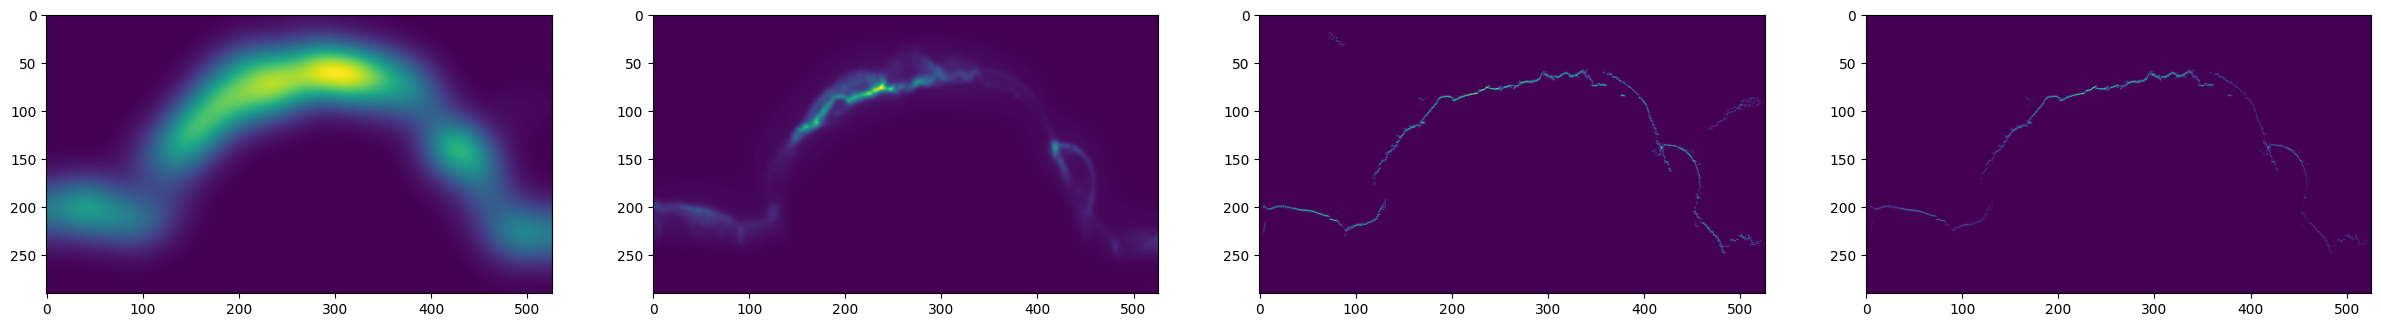

In [896]:
slice = 200
plt.figure(figsize=(30,20))
plt.subplot(341)
plt.imshow(filtered_mask_mask_r[slice])
plt.subplot(342)
plt.imshow(epithelial_mask_mask_r[slice])
plt.subplot(343)
plt.imshow(shape_finder_2D(epithelial_mask_mask_r[slice]))
plt.subplot(344)
plt.imshow(shape_finder_2D(epithelial_mask_mask_r[slice])*filtered_mask_mask_r[slice])

In [881]:
surface_cells_mask_r = []
c = 0
total = epithelial_mask_mask_r.shape[0]
for i in epithelial_mask_mask_r:
    surface_cells_mask_r.append(shape_finder_2D(i))
    c+=1
    print(f"{c}/{total}", end='\r')
surface_cells_mask_r = np.array(surface_cells_mask_r)

In [888]:
surface_cells_mask_filter_r = surface_cells_mask_r * filtered_mask_mask_r

In [891]:
surface_cells_mask = np.transpose(surface_cells_mask_r, axes=(1,2,0))
surface_cells_mask = normalize_image(surface_cells_mask, 65535)
surface_cells_mask = surface_cells_mask.astype(np.uint16)

surface_cells_mask_filter = np.transpose(surface_cells_mask_filter_r, axes=(1,2,0))
surface_cells_mask_filter = normalize_image(surface_cells_mask_filter, 65535)
surface_cells_mask_filter = surface_cells_mask_filter.astype(np.uint16)

# mean_indices_3d = mean_indices_3d.astype(np.uint16)
tiff.imwrite("./../ppujol/zmap/62 t"+time_dome+" cell surface mask x 2.tif", surface_cells_mask, imagej=True)
tiff.imwrite("./../ppujol/zmap/62 t"+time_dome+" cell surface mask x 2 filter.tif", surface_cells_mask_filter, imagej=True)

# End falling line

In [379]:
surface_cells = np.transpose(surface_cells_r, axes=(1,2,0))

dot_mask = surface_cells.astype(np.float64)
filtered_dot = gaussian_filter(dot_mask, 20)
epithelial_dot = filtered_dot*image

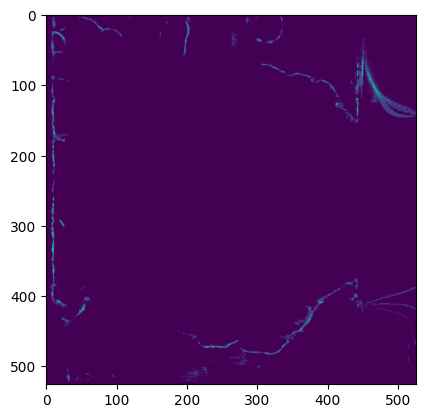

In [380]:
plt.imshow(surface_cells[200])

In [383]:
hull_dots = []


for i in surface_cells:
    if i.sum() == 0:
        hull_dots.append(i)
    else:
        hull_dots.append(sk.morphology.convex_hull_image(i))

hull_dots = np.array(hull_dots)
hull_dots = hull_dots.astype(np.uint8)

In [384]:
hull_dots_r = np.transpose(hull_dots, axes=(1,0,2))
hull_dots_r = np.transpose(hull_dots_r, axes=(2, 1, 0))
hull_dots_r = first_nonzero(hull_dots_r)
hull_dots  = np.transpose(hull_dots_r, axes=(1,2,0))

hull_dot_mask = hull_dots.astype(np.float64)
filtered_hull_dot = gaussian_filter(hull_dot_mask, 20)
epithelial_hull_dot = filtered_hull_dot*image

In [385]:
filtered_hull_dot_r = np.transpose(filtered_hull_dot, axes=(1,0,2))
filtered_hull_dot_r = np.transpose(filtered_hull_dot_r, axes=(2, 1, 0))

epithelial_hull_dot_r = np.transpose(epithelial_hull_dot, axes=(1,0,2))
epithelial_hull_dot_r = np.transpose(epithelial_hull_dot_r, axes=(2, 1, 0))

In [381]:
surface_cells = surface_cells.astype(np.uint16)
# mean_indices_3d = mean_indices_3d.astype(np.uint16)
tiff.imwrite("./../ppujol/zmap/62 t"+time_dome+" cell surface.tif", surface_cells, imagej=True)

In [386]:
filtered_dot_r = np.transpose(filtered_dot, axes=(1,0,2))
filtered_dot_r = np.transpose(filtered_dot_r, axes=(2, 1, 0))

In [387]:
epithelial_dot_r = np.transpose(epithelial_dot, axes=(1,0,2))
epithelial_dot_r = np.transpose(epithelial_dot_r, axes=(2, 1, 0))

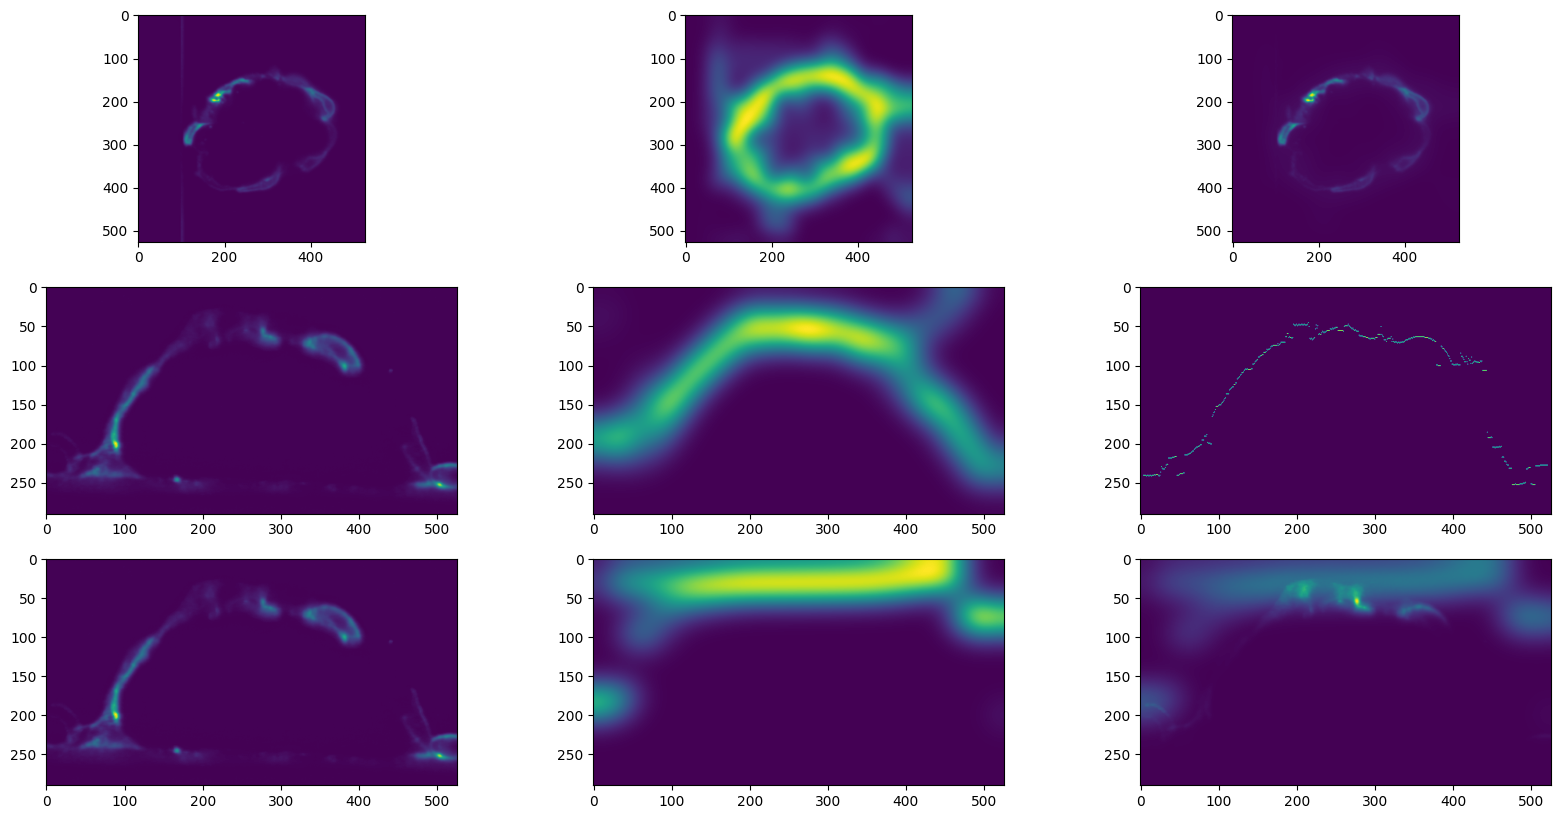

In [543]:
plt.figure(figsize=(20,10))
plt.subplot(331)
plt.imshow(image[100])
plt.subplot(332)
plt.imshow(filtered_dot[100])
plt.subplot(333)
plt.imshow(epithelial_dot[100])

plt.subplot(334)
plt.imshow(image_r[300])
plt.subplot(335)
plt.imshow(filtered_dot_r[300])
plt.subplot(336)
plt.imshow(surface_cells_r[300])

plt.subplot(337)
plt.imshow(image_r[300])
plt.subplot(338)
plt.imshow(filtered_hull_dot_r[300])
plt.subplot(339)
plt.imshow(epithelial_hull_dot_r[300])

In [389]:
max_intensity_indices = np.argmax(epithelial_r, axis=1)
max_intensity_values = np.max(epithelial_r, axis=1)

In [390]:
max_intensity_indices_sum = np.argmax(epithelial_sum_r, axis=1)
max_intensity_values_sum = np.max(epithelial_sum_r, axis=1)

In [391]:
max_intensity_indices_dot = np.argmax(epithelial_dot_r, axis=1)
max_intensity_values_dot = np.max(epithelial_dot_r, axis=1)

In [392]:
max_intensity_indices_hull_dot = np.argmax(epithelial_hull_dot_r, axis=1)
max_intensity_values_hull_dot = np.max(epithelial_hull_dot_r, axis=1)

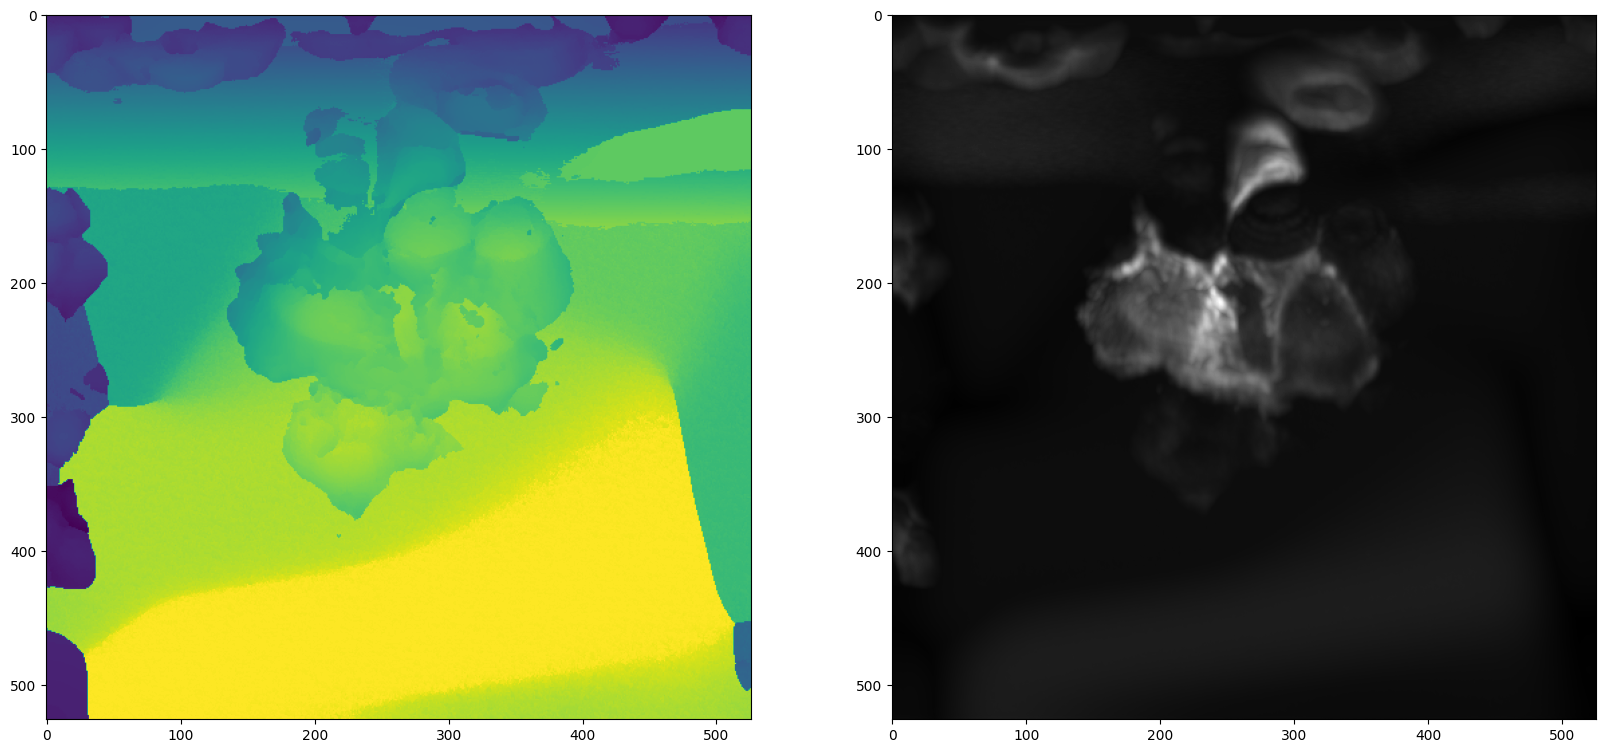

In [393]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(max_intensity_indices_hull_dot.max()-max_intensity_indices_hull_dot)
plt.subplot(122)

plt.imshow(max_intensity_values_hull_dot, cmap='gray')

In [243]:
tiff.imwrite("./../ppujol/zmap/62 t"+time_dome+" dot hull z height map.tif", normalize_image(max_intensity_indices_hull_dot, 65535).astype(np.uint16), imagej=True)
tiff.imwrite("./../ppujol/zmap/62 t"+time_dome+" dot hull z map.tif", normalize_image(max_intensity_values_hull_dot, 65535).astype(np.uint16), imagej=True)

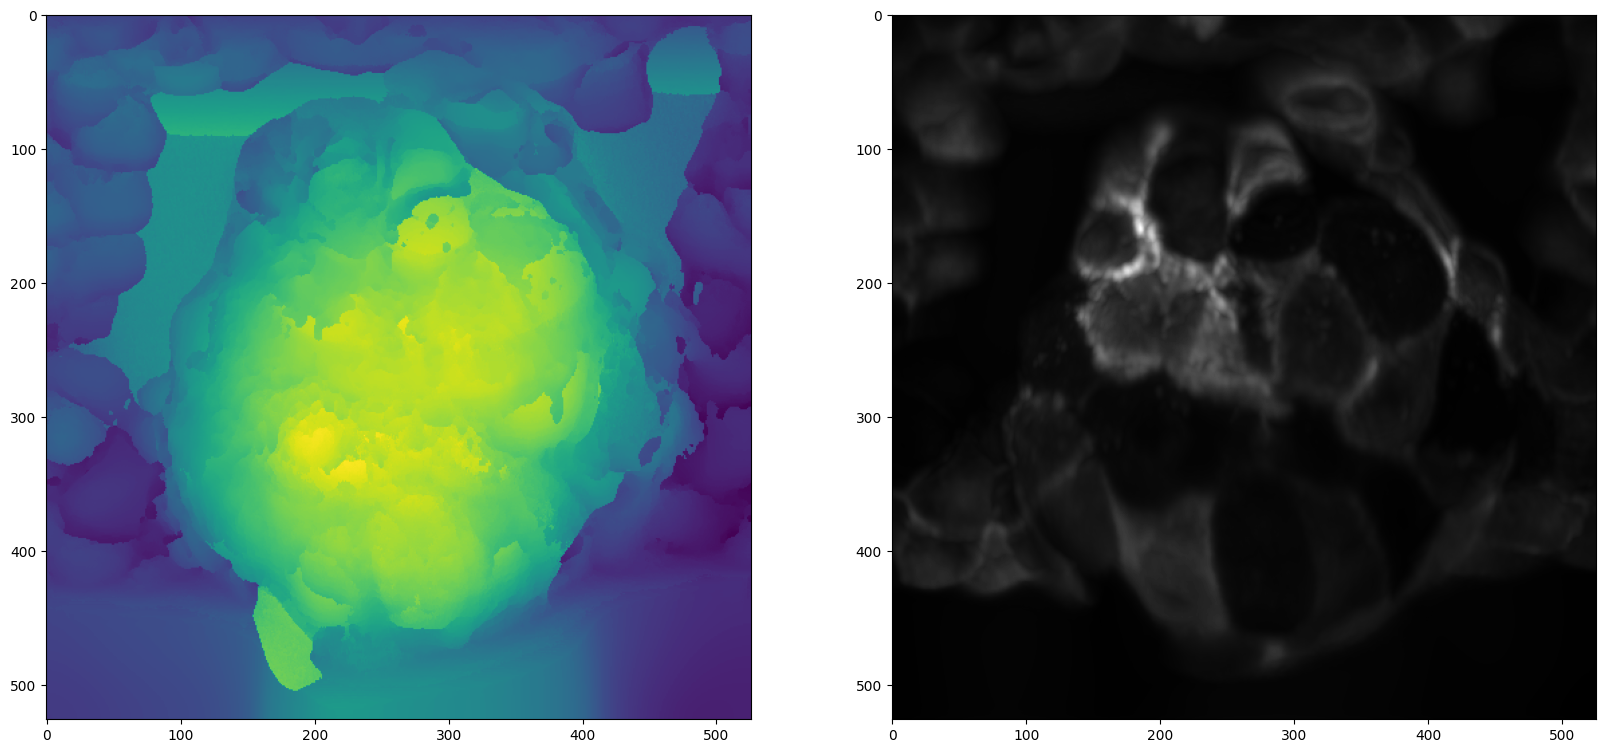

In [394]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(max_intensity_indices_dot.max()-max_intensity_indices_dot)
plt.subplot(122)

image_90 = np.transpose(image, (0,2,1))
values = image_90[max_intensity_indices_dot, np.arange(max_intensity_indices_dot.shape[0])[:, None], np.arange(max_intensity_indices_dot.shape[1])]

plt.imshow(max_intensity_values_dot, cmap='gray')

In [ ]:
tiff.imwrite("./../ppujol/zmap/62 t"+time_dome+" dot z height map.tif", normalize_image(max_intensity_indices_dot, 65535).astype(np.uint16), imagej=True)
tiff.imwrite("./../ppujol/zmap/62 t"+time_dome+" dot z map.tif", normalize_image(max_intensity_values_dot, 65535).astype(np.uint16), imagej=True)

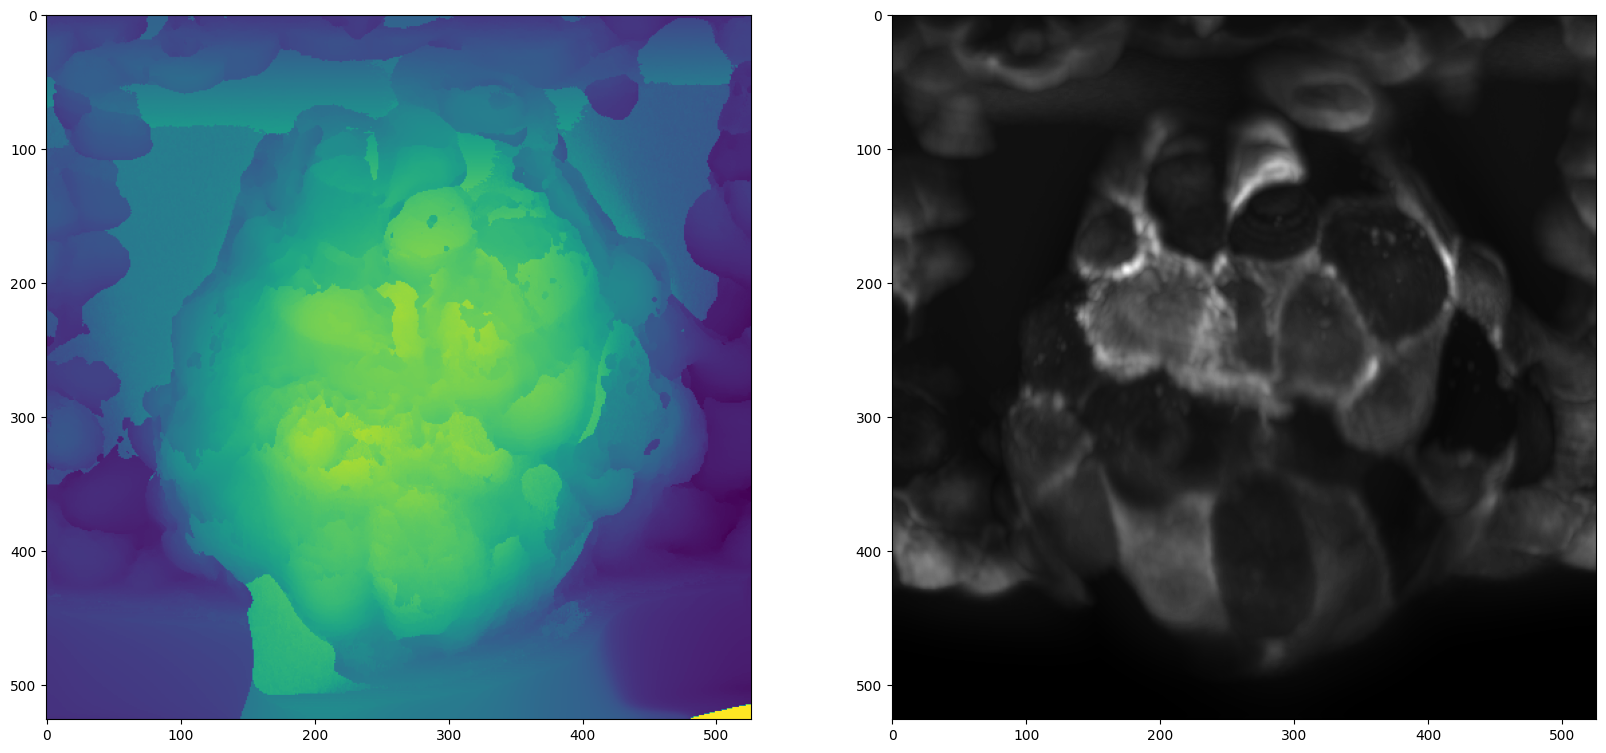

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(max_intensity_indices.max()-max_intensity_indices)
plt.subplot(122)
plt.imshow(max_intensity_values, cmap='gray')

In [188]:
tiff.imwrite("./../ppujol/zmap/62 t"+time_dome+" hull z height map.tif", normalize_image(max_intensity_indices, 65535).astype(np.uint16), imagej=True)
tiff.imwrite("./../ppujol/zmap/62 t"+time_dome+" hull z map.tif", normalize_image(max_intensity_values, 65535).astype(np.uint16), imagej=True)

NameError: name 'max_intensity_indices' is not defined

NameError: name 'max_intensity_indices_sum' is not defined

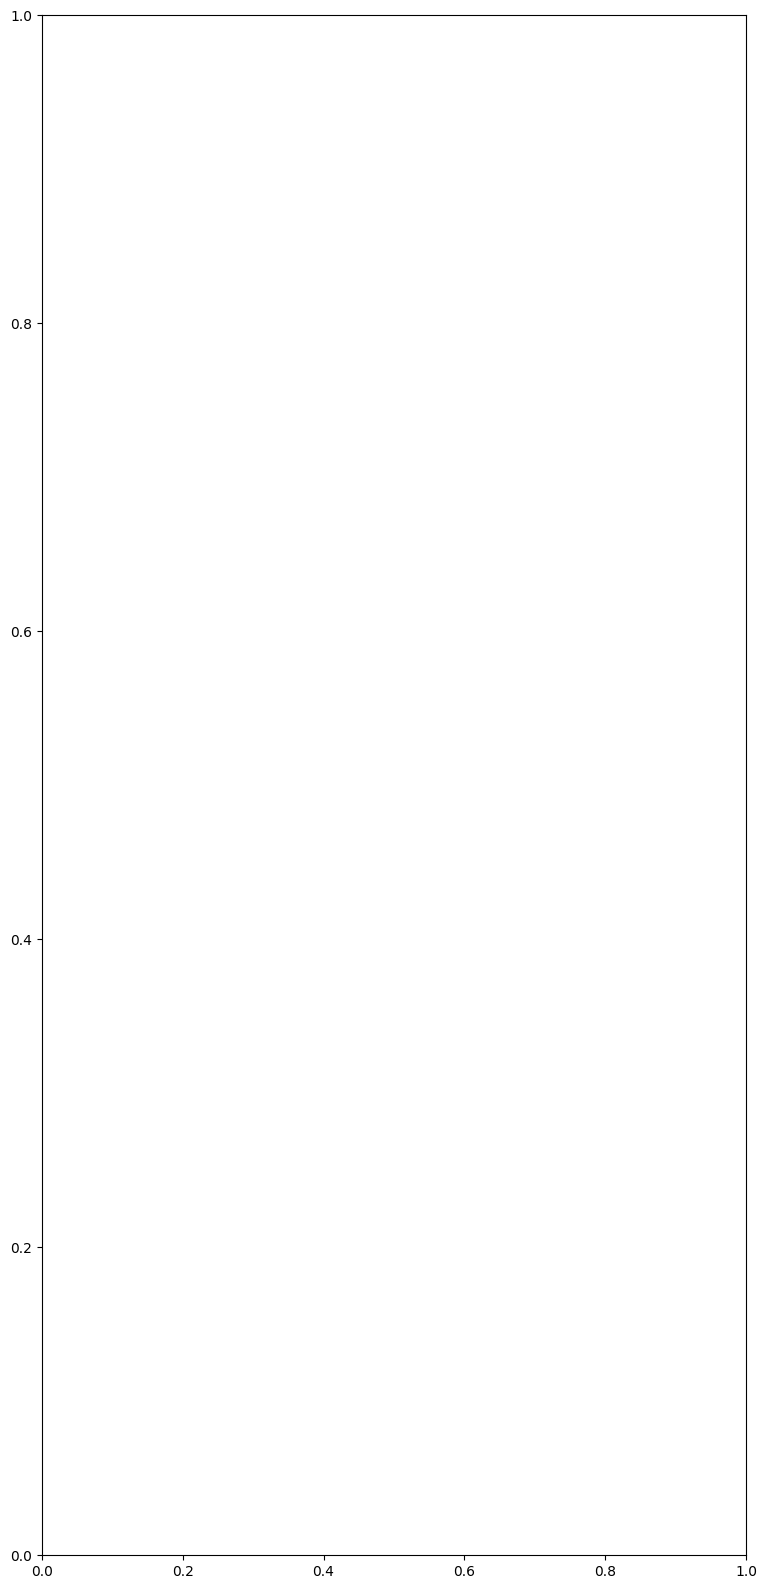

In [189]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(max_intensity_indices_sum.max()-max_intensity_indices_sum)
plt.subplot(122)
plt.imshow(max_intensity_values_sum)

In [274]:
tiff.imwrite("./../ppujol/zmap/62 t"+time_dome+" z height map sum lines.tif", normalize_image(max_intensity_indices_sum, 65535).astype(np.uint16), imagej=True)
tiff.imwrite("./../ppujol/zmap/62 t"+time_dome+" z map sum lines.tif", normalize_image(max_intensity_values_sum, 65535).astype(np.uint16), imagej=True)

# Try to smooth the height map.

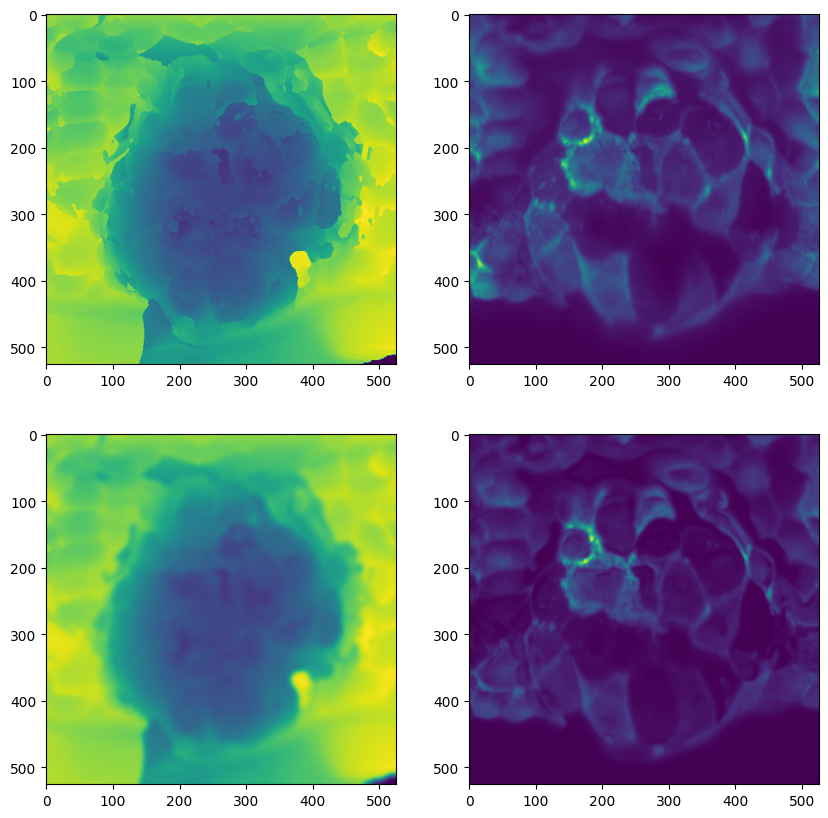

In [277]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(max_intensity_indices_sum)
plt.subplot(222)
plt.imshow(max_intensity_values_sum)
plt.subplot(223)
sigma = 4.0  # Standard deviation of the Gaussian kernel
smooth_map = gaussian_filter(max_intensity_indices_sum, sigma=sigma)
plt.imshow(smooth_map)
plt.subplot(224)
image_90 = np.transpose(image, (0,2,1))

# values = np.zeros((smooth_map.shape))
# for i in range(smooth_map.shape[0]):
#     for j in range(smooth_map.shape[1]):
#         values[i][j] = image_90[smooth_map[i,j], i, j]
# values = np.array(values)

values = image_90[smooth_map, np.arange(smooth_map.shape[0])[:, None], np.arange(smooth_map.shape[1])]

plt.imshow(values)

In [278]:
tiff.imwrite("./../ppujol/zmap/62 t"+time_dome+" z height map sum lines smooth.tif", normalize_image(smooth_map, 65535).astype(np.uint16), imagej=True)
tiff.imwrite("./../ppujol/zmap/62 t"+time_dome+" z map sum lines smooth.tif", normalize_image(values, 65535).astype(np.uint16), imagej=True)

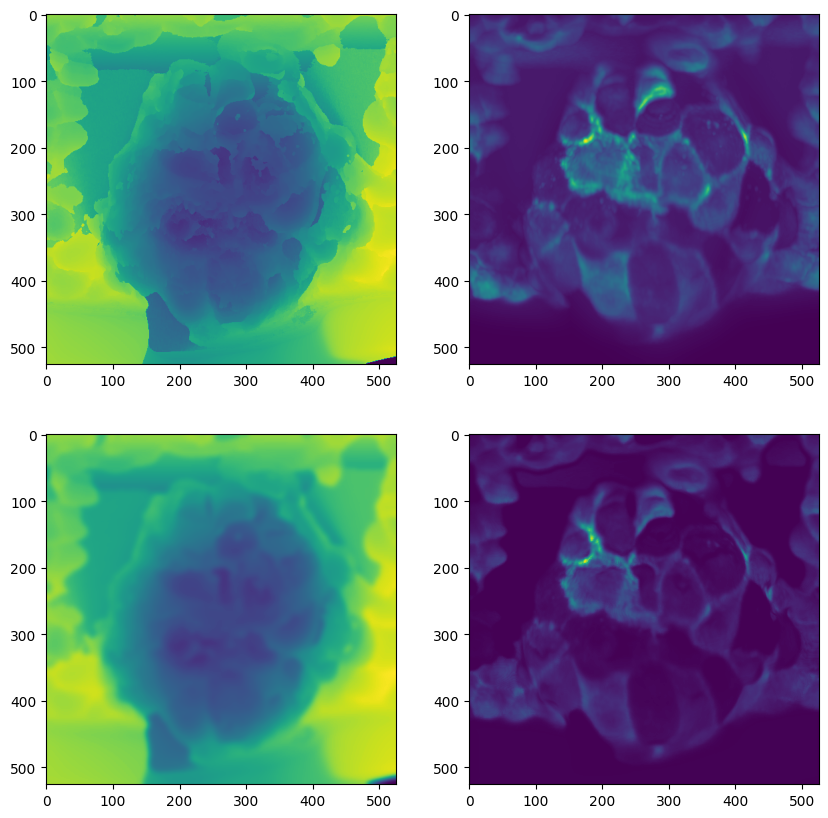

In [279]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(max_intensity_indices)
plt.subplot(222)
plt.imshow(max_intensity_values)
plt.subplot(223)
sigma = 4.0  # Standard deviation of the Gaussian kernel
smooth_map = gaussian_filter(max_intensity_indices, sigma=sigma)
plt.imshow(smooth_map)
plt.subplot(224)
image_90 = np.transpose(image, (0,2,1))

# values = np.zeros((smooth_map.shape))
# for i in range(smooth_map.shape[0]):
#     for j in range(smooth_map.shape[1]):
#         values[i][j] = image_90[smooth_map[i,j], i, j]
# values = np.array(values)

values = image_90[smooth_map, np.arange(smooth_map.shape[0])[:, None], np.arange(smooth_map.shape[1])]

plt.imshow(values)

In [ ]:
tiff.imwrite("./../ppujol/zmap/62 t"+time_dome+" z height map hull smooth.tif", normalize_image(smooth_map, 65535).astype(np.uint16), imagej=True)
tiff.imwrite("./../ppujol/zmap/62 t"+time_dome+" z map hull smooth.tif", normalize_image(values, 65535).astype(np.uint16), imagej=True)